In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-01-07 07:14:55--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-01-07 07:14:55 (11.2 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [46]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month', parse_dates = True)

In [47]:
df['LogPassengers'] = np.log(df['Passengers'])

In [48]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

### 1-step

In [49]:
# Make supervised dataset

series = df['LogPassengers'].to_numpy()

T = 10 # number of lags
X = [] # inputs
Y = [] # targets
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (134, 10) Y.shape (134,)


In [50]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [51]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.9599443783339898

In [52]:
lr.score(Xtest, Ytest)

0.6910953044565602

In [53]:
# Boolean index

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False

In [54]:
# 1-step forecast

df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

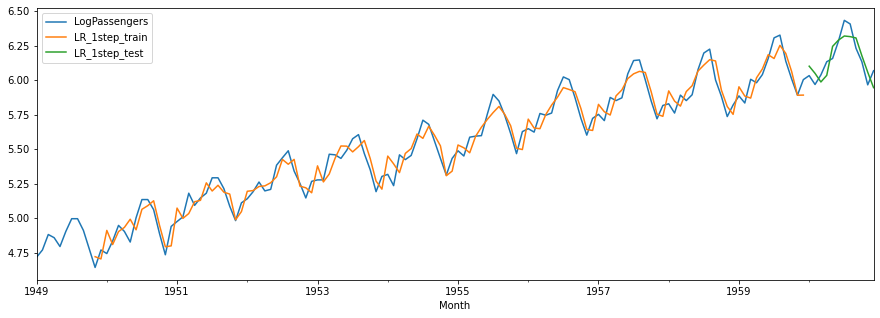

In [55]:
# Plot 1-step forecast

df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize = (15, 5));

### Multi-step

In [56]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = lr.predict(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [57]:
# Save multi-step forecast to the dataframe

df.loc[test_idx, 'LR_multistep'] = multistep_predictions

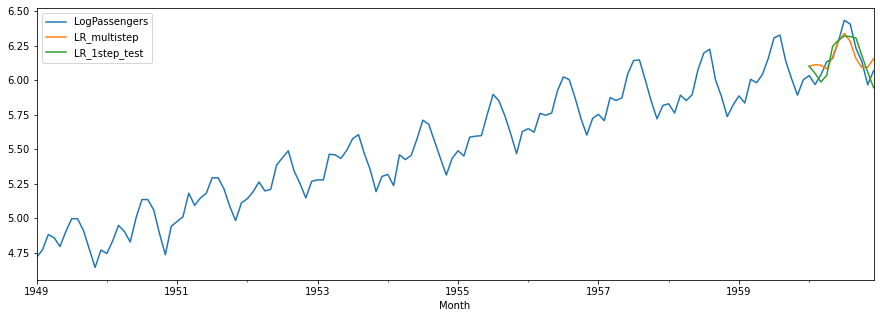

In [58]:
# Plot 1-step and multistep

df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize = (15, 5));

### Multi-Output

In [59]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [60]:
# Split into train and test
# 

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [61]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.9734607773512528

In [62]:
lr.score(Xtest_m, Ytest_m)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [63]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.8018749676715189

In [64]:
# Save output to dataframe

df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

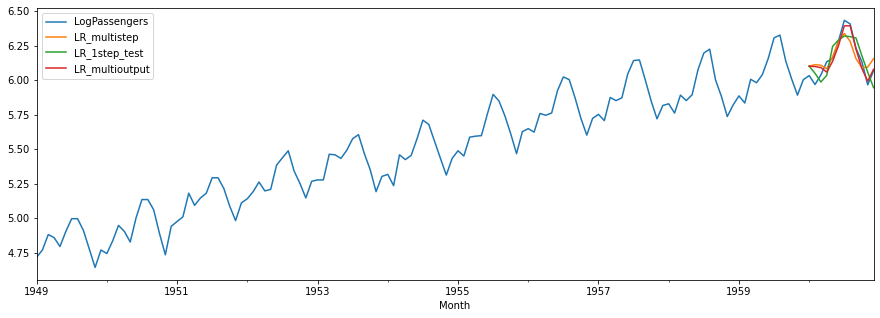

In [65]:
df[['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']].plot(figsize = (15, 5));

In [66]:
# Use different metric

# MAPE

mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, 'LR_multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.012229325023475299
Multi-output MAPE: 0.007178924475039815


### Test Other Models

#### One-step and Multi-step

In [70]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step Forecast:", name)

  # Store 1-step forecast

  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # Generate multi-step forecast

  multistep_predictions = []

  # First test input

  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]

    # Update the predictions list

    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  # Store multi-step forecast

  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast

  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print('Test MAPE (multi-step):', mape)

  # Plot 1-step and multi-step forecast
  df[['LogPassengers', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']].plot(figsize = (15, 5));

One-step Forecast: SVR
Test MAPE (multi-step): 0.017529446164230467


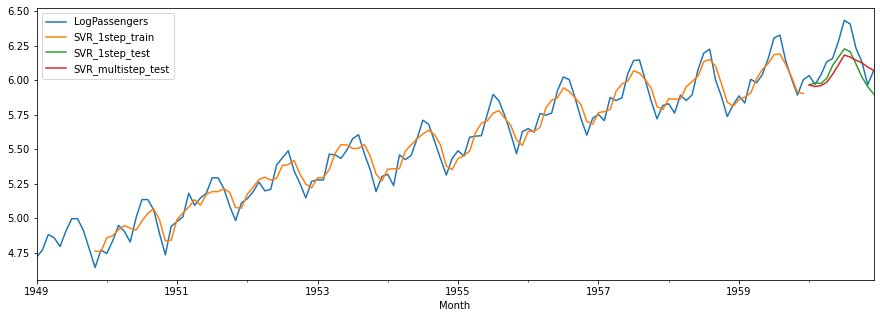

In [71]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step Forecast: RF
Test MAPE (multi-step): 0.01691257188059462


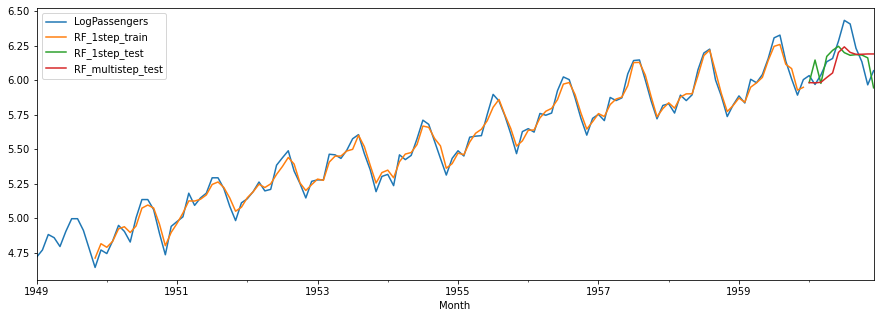

In [72]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

#### Multi-output

In [79]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)

  # Store multioutput forecast to dataframe

  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  # MAPE of multioutput forecast

  mape = mean_absolute_percentage_error(Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print('Test MAPE (multioutput):', mape)

  # Plot 1-step and multi-step forecast
  df[['LogPassengers', f'{name}_1step_train',
      f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']].plot(figsize = (15, 5));

In [80]:
# SVR cannot handle multiple output

multi_output_forecast(SVR(), "SVR")

ValueError: ignored

Test MAPE (multioutput): 0.016546968446791762


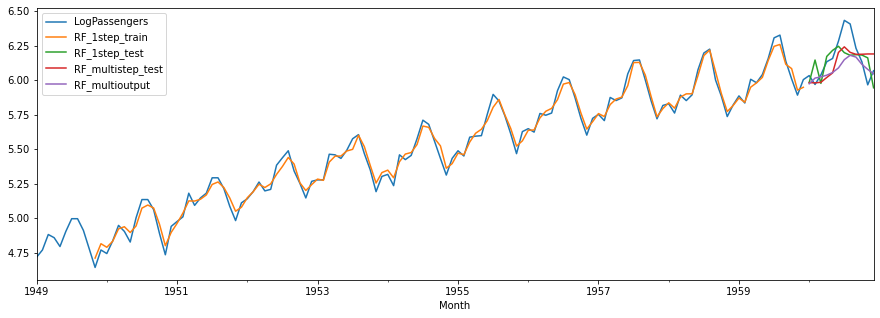

In [81]:
multi_output_forecast(RandomForestRegressor(), "RF")